In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
import tensorflow as tf
import tensorflow_quantum as tfq
from hep_VQAE import data_preprocessing as dp
from hep_VQAE import CAE as cae
import h5py
import keras
import numpy as np
from tensorflow.keras.utils import Sequence

2022-07-27 17:16:02.319932: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-27 17:16:02.319953: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/tom/.conda/envs/tfq/lib/python3.9/site-packages/cirq/ops/gateset.py:376: UserWarning: v0.14.1 is the last release `cirq.GlobalPhaseGate` is included by default. If you were relying on this behavior, you can include a `cirq.GlobalPhaseGate` in your `*gates`. If not, then you can ignore this warning. It will be removed in v0.16
  warnings.warn(
2022-07-27 17:16:03.540561: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-27 17:16:03.540585: W tensorflow/

In [2]:
f3 = h5py.File("../../data/quark-gluon/quark-gluon_train-set_n793900.hdf5","r")
f2 = h5py.File("../../data/quark-gluon/quark-gluon_test-set_n10000.hdf5","r")
f = h5py.File("../../data/quark-gluon/quark-gluon_test-set_n139306.hdf5","r")

In [3]:
x_train = f.get('X_jets')
y_train = f.get('y')

x_val = f2.get('X')
y_val = f2.get('y')

x_test = f2.get('X')
y_test = f2.get('y')

In [4]:
x_val_ones = x_val[y_val[()]==1]
x_val = x_val[y_val[()]==0]

div1 = np.max(x_val, axis=(1,2)).reshape((x_val.shape[0],1,1,3))
div1[div1 == 0] = 1
x_val = x_val / div1
div2 = np.max(x_val_ones, axis=(1,2)).reshape((x_val_ones.shape[0],1,1,3))
div2[div2 == 0] = 1
x_val_ones = x_val_ones / div2



x_test = x_val
x_test_ones = x_val_ones

In [5]:
batch_size = 900
num_batches = x_train.shape[0]//batch_size

In [6]:
#maxx = 0
#minn = 10000000

#for i in range(int(num_batches)):
#    y = y_train[i * batch_size: (i + 1) * batch_size]
#    cmax = np.max(np.log(x_train[i * batch_size: (i + 1) * batch_size][y==0] + 1))
#    if cmax > maxx:
#        maxx = cmax
#    cmin = np.min(np.log(x_train[i * batch_size: (i + 1) * batch_size][y==0] + 1) )
#    if cmin < minn:
#        minn = cmin
#    print(i, end="\r")
#    
#print(maxx)
#print(minn)

In [7]:
from sklearn.preprocessing import normalize

class Generator(Sequence) :
  
    def __init__(self, hdf5_file, y_hdf5_file, batch_size, y_train_selection) :
        self.hdf5_file = hdf5_file
        self.batch_size = batch_size
        self.y_train_selection = y_train_selection
        self.y_hdf5_file = y_hdf5_file
    
  # Länge der Trainingsdaten (Anzahl der Batches)
    def __len__(self) :
        return x_train.shape[0]//self.batch_size
  
    def __getitem__(self, idx):
        y = self.y_hdf5_file[idx * self.batch_size: (idx + 1) * self.batch_size]
        x = self.hdf5_file[idx * self.batch_size: (idx + 1) * self.batch_size][y==self.y_train_selection]
        maxnorm = np.max(x, axis=(1,2)).reshape((x.shape[0], 1, 1, 3))
        maxnorm[maxnorm == 0] = 1
        return x / maxnorm , x / maxnorm

In [9]:
traingen = Generator(x_train, y_train, batch_size, 0)

In [10]:
model = cae.QG_Convolutional_Autoencoder(1024)

In [11]:
model.encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 125, 125, 16)      1744      
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 16)      9232      
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 30, 64)        18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 30, 30, 64)        36928     
                                                                 
 conv2d_6 (Conv2D)           (None, 15, 15, 30)        1

In [12]:
#model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=0.05))
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001))

/home/tom/.conda/envs/tfq/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [13]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, min_delta=1e-5)
hist = model.fit_generator(traingen,epochs=8,validation_data=(x_val,x_val))

/tmp/ipykernel_435472/566222503.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(traingen,epochs=8,validation_data=(x_val,x_val))


Epoch 1/8
154/154 [==============================] - 6574s 43s/step - loss: 0.0419 - val_loss: 0.0117
Epoch 2/8
154/154 [==============================] - 6612s 43s/step - loss: 0.0114 - val_loss: 0.0111
Epoch 3/8
154/154 [==============================] - 6515s 42s/step - loss: 0.0106 - val_loss: 0.0103
Epoch 4/8
154/154 [==============================] - 6203s 40s/step - loss: 0.0097 - val_loss: 0.0093
Epoch 5/8
154/154 [==============================] - 6330s 41s/step - loss: 0.0089 - val_loss: 0.0086
Epoch 6/8
154/154 [==============================] - 6336s 41s/step - loss: 0.0083 - val_loss: 0.0084
Epoch 7/8
154/154 [==============================] - 6312s 41s/step - loss: 0.0078 - val_loss: 0.0075
Epoch 8/8
154/154 [==============================] - 6353s 41s/step - loss: 0.0074 - val_loss: 0.0074


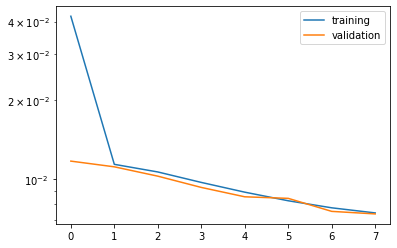

In [17]:
plt.plot(hist.history['loss'], label="training")
plt.plot(hist.history['val_loss'], label="validation")
plt.yscale('log')
plt.legend()

In [15]:
def mae(x):
    pred = model.predict(x)
    return np.mean(np.abs(x - pred)**2,axis=(1,2,3))

def recon_acc(x):
    return 1 - mae(x)

In [20]:
zerrooo = recon_acc(x_test[:100])
one = recon_acc(x_test[100:200])

0.495


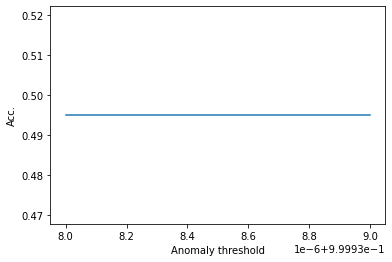

In [22]:
def acc_for_threshold(T):
    # sixes that are predicted six
    num_six_right = np.sum(zerrooo > T)
    # threes that are predicted three
    num_three_right = np.sum(one < T)
    acc = (num_six_right + num_three_right)/(len(zerrooo) + len(one))
    return acc

Ts = np.linspace(0.999938,0.999939,1000)
accs = []
for i in Ts:
    accs.append(acc_for_threshold(i))
print(max(accs))
plt.xlabel("Anomaly threshold")
plt.ylabel("Acc.")
plt.plot(Ts, accs)  

In [24]:
model.encoder(x_val_zeroes[:10]).numpy()

NameError: name 'x_val_zeroes' is not defined

In [31]:
testimg = model((x_test[20]).reshape((1,125,125,3)))

In [32]:
testimg[testimg>0]

<tf.Tensor: shape=(46875,), dtype=float32, numpy=
array([0.00957042, 0.00994343, 0.01089546, ..., 0.00221717, 0.00234771,
       0.00098795], dtype=float32)>

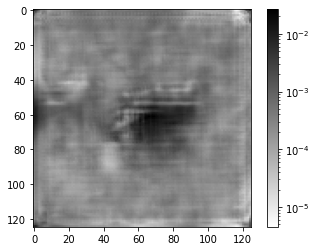

In [35]:
from matplotlib.colors import LogNorm
plt.imshow(testimg[0,:,:,0],cmap='binary',norm=LogNorm())
plt.colorbar()

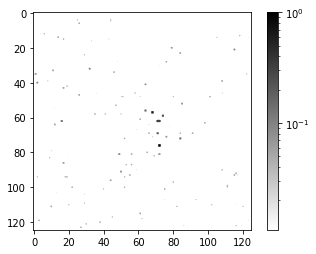

In [36]:
plt.imshow(x_test[20,:,:,0],cmap='binary',norm=LogNorm())
plt.colorbar()

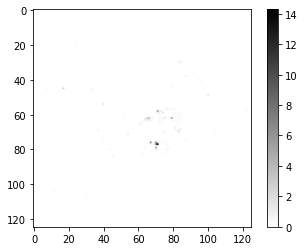

In [29]:
plt.imshow(x_test[20,:,:,1]/0.07,cmap='binary')
plt.colorbar()

In [37]:
from hep_VQAE import utils as ut

In [45]:
recon = model.predict(x_test[:100])

ut.eval_recon(x_test[:100][:,:,:,0], recon[:,:,:,0], lognorm=True)

RuntimeError: EMDStatus - MaxIterReached, consider increasing n_iter_max

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.colors import LogNorm
from matplotlib import cm
from sklearn.metrics import roc_auc_score, roc_curve
import energyflow as ef


def eval_recon2(x_test, x_recon, lognorm=False):
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2],1)
    x_recon = x_recon.reshape(x_recon.shape[0], x_recon.shape[1], x_recon.shape[2],1)

    collapse_metric = ut.test_collapse(x_test, x_recon)
    ssim = tf.reduce_mean(tf.image.ssim(x_test.astype('float64'), x_recon.astype('float64'), max_val=1.0)).numpy()
    MAE = tf.reduce_mean(tf.abs(x_test - x_recon)).numpy()
    normalized_MAE = MAE / tf.reduce_mean(tf.reduce_sum(x_test,axis=(1,2)).numpy().reshape((x_test.shape[0],1,1,1))).numpy()


    print(f'Collapse_metric: {collapse_metric:.3}')
    print(f'ssim: {ssim:.3}')
    print(f'MAE: {MAE:.3}')
    print(f'normalized MAE: {normalized_MAE:.3}')

    fig, axs = plt.subplots(2,3, figsize=(10, 5))

    if lognorm:
        norm = LogNorm()
    else:
        norm = None

    for i in range(3):
        rint = np.random.randint(len(x_test))
        axs[0,i].imshow(x_test[rint], cmap='binary', norm=norm)
        axs[0,i].title.set_text('true')

        fig.colorbar(cm.ScalarMappable(norm=norm, cmap='binary'), ax=axs[0,i])

        axs[1,i].imshow(x_recon[rint], cmap='binary', norm=norm)
        axs[1,i].title.set_text('reconstructed')

        fig.colorbar(cm.ScalarMappable(norm=norm, cmap='binary'), ax=axs[1,i])

    fig.tight_layout()

Collapse_metric: 0.462
ssim: 0.965
MAE: 0.00115
normalized MAE: 0.000114


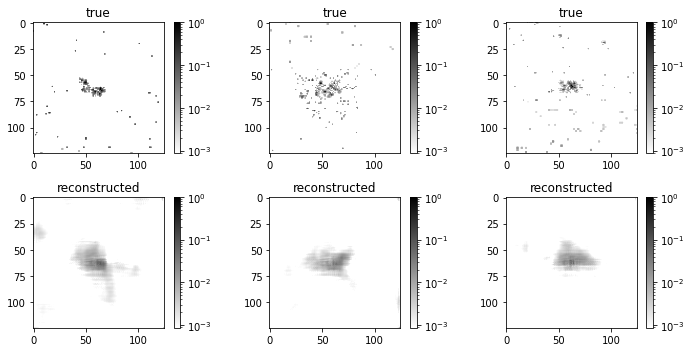

In [86]:
recon = model.predict(x_test[:100])

eval_recon2(x_test[:100][:,:,:,1], recon[:,:,:,1], lognorm=True)

Collapse_metric: 0.545
ssim: 0.974
MAE: 0.000916
normalized MAE: 0.000121


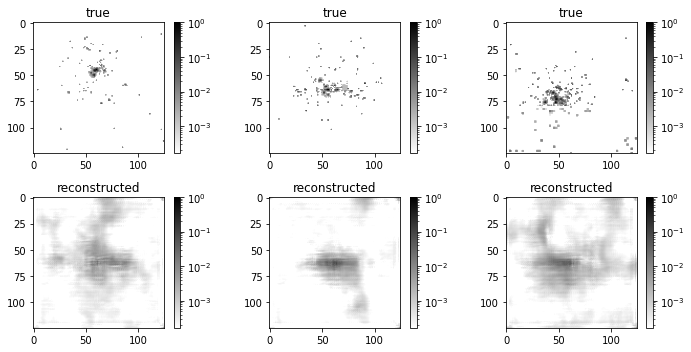

In [80]:
recon = model.predict(x_test_ones[:100])

eval_recon2(x_test_ones[:100][:,:,:,1], recon[:,:,:,1], lognorm=True)

Median background: 0.0133
Median signal: 0.00972
Maximum accuracy: 0.5
AUC: 0.369


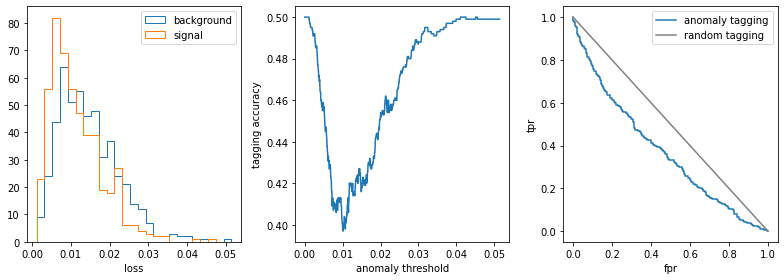

In [85]:
recon = model.predict(x_test[:500])
recon_1 = model.predict(x_test_ones[:500])

ut.eval_tagging(x_test[:500][:,:,:,2], recon[:,:,:,2], x_test_ones[:500][:,:,:,2], recon_1[:,:,:,2])